In [1]:
import pandas as pd
import json, os

import tensorflow as tf
import numpy as np
import csv
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification #, BertModel, BertTokenizer, TFBertForSequenceClassification
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from collections import OrderedDict
import time
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import random
import io

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Embedding, MaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import glorot_uniform, RandomUniform, lecun_uniform, Constant, TruncatedNormal
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D, Flatten
import tensorflow.keras.backend as K

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D

from sklearn.metrics import classification_report
from keras_preprocessing.text import tokenizer_from_json

import nltk
from nltk.tokenize import word_tokenize

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l1_l2

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
from nlpaug.util.file.download import DownloadUtil


In [2]:
seed = 123
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
embeddings = ["w2v", "ft", "bert", "codebert"]
embedding = embeddings[3]

Choose a project among Chrome and Linux or the full dataset

In [4]:
#data = pd.read_csv(os.path.join('..','data', 'full_data_reduced.csv'))
data = pd.read_csv(os.path.join('..','data', 'chrome_data_reduced.csv'))
#data = pd.read_csv(os.path.join('..','data', 'linux_data_reduced.csv'))

Shuffle the dataset before starting operating on it

In [5]:
data = data.sample(frac=1, random_state=seed).reset_index(drop=True)

In [6]:
print(data.head())

                                                func  vul  length
0    midimanagerusbtest() : message_loop_(new bas...    0      14
1  void renderframehostimpl::cancelblockedrequest...    0       8
2  void renderthreadimpl::removeobserver(renderth...    0       7
3  void webstorestandaloneinstaller::initinstalld...    0       7
4  omniboxstate::omniboxstate(const omniboxeditmo...    0      15


In [7]:
np.max(data["length"])

80

In [8]:
word_counts = data["func"].apply(lambda x: len(x.split()))
max_length = word_counts.max()
print("Maximum number of words:", max_length)


Maximum number of words: 80


In [9]:
vc = data["vul"].value_counts()

print(vc)

print("Vulnerability Percentage: ", (vc[1] / vc[0])*100, '%')

0    70232
1     3000
Name: vul, dtype: int64
Vulnerability Percentage:  4.271557124957284 %


Train-val-test split

In [10]:
# split data into train and test and then train into train and val (90% train, 10% test and then 90% train and 10% val)
shuffle_seeders = [seed, 10, 15, 20, 25, 30, 35, 40, 45, 50]
shuffle_seeder = shuffle_seeders[0]

x_train_val, x_test, y_train_val, y_test = train_test_split(data["func"].tolist(), data["vul"].tolist(), stratify = data["vul"].tolist(), test_size=0.1, random_state=shuffle_seeder)

x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify = y_train_val, test_size=0.1, random_state=shuffle_seeder)


<b>Handling imbalanced data</b>

Class weighting

In [11]:
class_weights = {0:1, 1:1}
#class_weights = {0:len(data) / (len(vc) * vc[0]), 1:len(data) / (len(vc) * vc[1])} #total observations / (number of classes * observations in class)
#class_weights = dict(enumerate(compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)))
print(class_weights)

{0: 1, 1: 1}


Under-sampling of the clean samples

In [12]:
x_train = np.array(x_train)
x_train = x_train.reshape(-1, 1)
x_train.shape

(59317, 1)

In [13]:
# Apply under-sampling with the specified strategy
class_counts = pd.Series(y_train).value_counts()
print("Class distribution ", class_counts)
majority_class = class_counts.idxmax()
print("Majority class ", majority_class)
target_count = int(class_counts.iloc[0] / 2) 
print("Targeted number of majority class", target_count)

# under
sampling_strategy = {majority_class: target_count}        
rus = RandomUnderSampler(random_state=seed, sampling_strategy=sampling_strategy)
x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train) 
print("Class distribution after augmentation", pd.Series(y_train_resampled).value_counts())

Class distribution  0    56887
1     2430
dtype: int64
Majority class  0
Targeted number of majority class 28443
Class distribution after augmentation 0    28443
1     2430
dtype: int64


In [14]:
x_train_resampled = x_train_resampled.tolist()

Random word augmentation

In [15]:
# aug = naw.RandomWordAug(action='delete', name='RandomWord_Aug', aug_min=1, aug_max=10, aug_p=0.3, stopwords=None, 
#                         target_words=None, tokenizer=None, reverse_tokenizer=None, stopwords_regex=None, verbose=0)

# num_minority_samples = pd.Series(y_train_resampled).value_counts()[1]
# num_majority_samples = pd.Series(y_train_resampled).value_counts()[0]
# difference  = num_majority_samples - num_minority_samples
# num_augmentations_per_sentence = difference // num_minority_samples

# x_augm = []
# y_augm = []
# for i in range(0, len(x_train_resampled)):
#     # check for minority class
#     if y_train_resampled[i] == 1:
#         sentence = x_train_resampled[i]
        
#         for _ in range(num_augmentations_per_sentence):
#             # Apply synonym augmentation
#             augmented_sentence = aug.augment(sentence[0])
#             # Store the augmented sentence
#             x_augm.append(augmented_sentence)
#             y_augm.append(1)
            
# x_train_resampled = x_train_resampled + x_augm
# y_train_resampled = y_train_resampled + y_augm

# print("Class distribution after augmentation", pd.Series(y_train_resampled).value_counts())

Synonym word augmentation

In [16]:
# aug = naw.SynonymAug(aug_src='wordnet', model_path=None, name='Synonym_Aug', aug_min=1, aug_max=10, aug_p=0.3, lang='eng', 
#                      stopwords=None, tokenizer=None, reverse_tokenizer=None, stopwords_regex=None, force_reload=False, 
#                      verbose=0)

# num_minority_samples = pd.Series(y_train_resampled).value_counts()[1]
# num_majority_samples = pd.Series(y_train_resampled).value_counts()[0]
# difference  = num_majority_samples - num_minority_samples
# num_augmentations_per_sentence = difference // num_minority_samples

# x_augm = []
# y_augm = []
# for i in range(0, len(x_train_resampled)):
#     # check for minority class
#     if y_train_resampled[i] == 1:
#         sentence = x_train_resampled[i]
        
#         for _ in range(num_augmentations_per_sentence):
#             # Apply synonym augmentation
#             augmented_sentence = aug.augment(sentence[0])
#             # Store the augmented sentence
#             x_augm.append(augmented_sentence)
#             y_augm.append(1)
            
# x_train_resampled = x_train_resampled + x_augm
# y_train_resampled = y_train_resampled + y_augm

# print("Class distribution after under-sampling", pd.Series(y_train_resampled).value_counts())

Word2vec similar words augmentation - substitution

In [17]:
#DownloadUtil.download_word2vec(dest_dir='.') # Download word2vec model
#DownloadUtil.download_glove(model_name='glove.6B', dest_dir='.') # Download GloVe model

In [18]:
# # aug_w2v = naw.WordEmbsAug(
# #     model_type='word2vec', model_path='GoogleNews-vectors-negative300.bin',
# #     action="substitute")

# aug_w2v = naw.WordEmbsAug(
#     model_type='word2vec', model_path='w2v_model.model',
#     action="substitute")

# num_minority_samples = pd.Series(y_train_resampled).value_counts()[1]
# num_majority_samples = pd.Series(y_train_resampled).value_counts()[0]
# difference  = num_majority_samples - num_minority_samples
# num_augmentations_per_sentence = difference // num_minority_samples

# x_augm = []
# y_augm = []
# for i in range(0, len(x_train_resampled)):
#     # check for minority class
#     if y_train_resampled[i] == 1:
#         sentence = x_train_resampled[i]
        
#         for _ in range(num_augmentations_per_sentence):
#             # Apply synonym augmentation
#             augmented_sentence = aug_w2v.augment(sentence[0])
#             # Store the augmented sentence
#             x_augm.append(augmented_sentence)
#             y_augm.append(1)
            
# x_train_resampled = x_train_resampled + x_augm
# y_train_resampled = y_train_resampled + y_augm

# print("Class distribution after under-sampling", pd.Series(y_train_resampled).value_counts())

FastText similar words augmentation

In [19]:
#DownloadUtil.download_fasttext(model_name='wiki-news-300d-1M', dest_dir='.') # Download fasttext model

In [20]:
# aug_w2v = naw.WordEmbsAug(
#     model_type='fasttext', model_path='.',
#     action="substitute")

# num_minority_samples = pd.Series(y_train_resampled).value_counts()[1]
# num_majority_samples = pd.Series(y_train_resampled).value_counts()[0]
# difference  = num_majority_samples - num_minority_samples
# num_augmentations_per_sentence = difference // num_minority_samples

# x_augm = []
# y_augm = []
# for i in range(0, len(x_train_resampled)):
#     # check for minority class
#     if y_train_resampled[i] == 1:
#         sentence = x_train_resampled[i]
        
#         for _ in range(num_augmentations_per_sentence):
#             # Apply synonym augmentation
#             augmented_sentence = aug_w2v.augment(sentence[0])
#             # Store the augmented sentence
#             x_augm.append(augmented_sentence)
#             y_augm.append(1)

# x_train_resampled = x_train_resampled + x_augm
# y_train_resampled = y_train_resampled + y_augm

# print("Class distribution after under-sampling", pd.Series(y_train_resampled).value_counts())

Contextual augmentation

In [21]:
# TOPK = 50 #default=100 # 20
# ACT = 'substitute' #"substitute" #"insert"
 
# aug_bert = naw.ContextualWordEmbsAug(
#     model_path='microsoft/codebert-base-mlm', 
#     #device='cuda',
#     action=ACT, top_k=TOPK)

# num_minority_samples = pd.Series(y_train_resampled).value_counts()[1]
# num_majority_samples = pd.Series(y_train_resampled).value_counts()[0]
# difference  = num_majority_samples - num_minority_samples
# num_augmentations_per_sentence = difference // num_minority_samples

# x_augm = []
# y_augm = []
# for i in range(0, len(x_train_resampled)):
#     # check for minority class
#     if y_train_resampled[i] == 1:
#         sentence = x_train_resampled[i]
#         for _ in range(num_augmentations_per_sentence):
#             # Apply synonym augmentation
#             augmented_sentence = aug_bert.augment(sentence[0])
#             # Store the augmented sentence
#             x_augm.append(augmented_sentence)
#             y_augm.append(1)
            
# x_train_resampled = x_train_resampled + x_augm
# y_train_resampled = y_train_resampled + y_augm

# print("Class distribution after under-sampling", pd.Series(y_train_resampled).value_counts())

In [22]:
# resampled_df = pd.DataFrame({'func': x_train_resampled, 'vul': y_train_resampled})
# resampled_df.to_csv('augmented_data.csv', index=False)

In [23]:
# Shuffle the resampled data while preserving the correspondence between features and labels
x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=seed)

# rename
X_train = x_train_resampled
Y_train = y_train_resampled

BERT pre-trained embeddings

In [24]:
if embedding == "bert":
    model_variation = "bert-base-uncased" # "roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(model_variation)
    bert = TFAutoModel.from_pretrained(model_variation)

In [25]:
if embedding == "bert":
    bert_embeddings = bert.get_input_embeddings()
    embedding_matrix = bert_embeddings.weights[0].numpy()
    num_words = len(embedding_matrix)
    print(num_words)
    dim = len(embedding_matrix[0])
    print(dim)

In [26]:
if embedding == "bert":
    sentences = X_train.tolist()
    sequences = [tokenizer.encode(sente[0], truncation=True, add_special_tokens=False, return_tensors="tf").numpy() for sente in sentences] # Tokenize the complete sentences


In [27]:
if embedding == "bert":
    lines_pad_x_train = []
    for seq in sequences:
        lines_pad_x_train.append(seq[0])

    lines_pad_x_train = pad_sequences(lines_pad_x_train, padding = 'post', maxlen = 512)
    lines_pad_x_train

In [28]:
if embedding == "bert":
    sentences = x_val
    sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="tf").numpy() for sente in sentences] # Tokenize the complete sentences


In [29]:
if embedding == "bert":
    lines_pad_x_val = []
    for seq in sequences:
        lines_pad_x_val.append(seq[0])

    lines_pad_x_val = pad_sequences(lines_pad_x_val, padding = 'post', maxlen = 512)
    lines_pad_x_val

CodeBERT pre-trained embeddings

In [30]:
if embedding == "codebert":
    model_variation = "microsoft/codebert-base-mlm" # "neulab/codebert-cpp"
    tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=False) # , do_lower_case=True
    codebert = TFAutoModel.from_pretrained(model_variation) # , from_pt=True

Some layers from the model checkpoint at microsoft/codebert-base-mlm were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at microsoft/codebert-base-mlm.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [31]:
if embedding == "codebert":
    codebert_embeddings = codebert.get_input_embeddings()
    embedding_matrix = codebert_embeddings.weights[0].numpy()
    num_words = len(embedding_matrix)
    print(num_words)
    dim = len(embedding_matrix[0])
    print(dim)

50265
768


In [32]:
if embedding == "codebert":
    sentences = X_train
    sequences = [tokenizer(sente[0], return_tensors="tf", truncation=True, add_special_tokens=False) for sente in sentences]

In [33]:
def padSequences(sequences, max_len):
    lines_pad = []
    for sequence in sequences:
        seq = sequence['input_ids'].numpy()[0]
        if len(seq) < max_len:
            for i in range(len(seq), max_len):
                seq = np.append(seq, 0)
        lines_pad.append(seq)
    return lines_pad


In [34]:
def get_max_len(sequences):
    max_len = 0
    
    for seq in sequences:
        if len(seq['input_ids'].numpy()[0]) > max_len:
            max_len = len(seq['input_ids'].numpy()[0])
    
    return max_len

In [35]:
if embedding == "codebert":
    max_len = get_max_len(sequences)
    print(max_len)

512


In [36]:
if embedding == "codebert":
    lines_pad_x_train = padSequences(sequences, max_len)
    lines_pad_x_train = [arr.tolist() for arr in lines_pad_x_train]
    lines_pad_x_train = np.array(lines_pad_x_train)

In [37]:
if embedding == "codebert":
    sentences = x_val
    sequences = [tokenizer(sente, return_tensors="tf", truncation=True, add_special_tokens=False) for sente in sentences]

In [38]:
if embedding == "codebert":
    lines_pad_x_val = padSequences(sequences, max_len)
    lines_pad_x_val = [arr.tolist() for arr in lines_pad_x_val]
    lines_pad_x_val = np.array(lines_pad_x_val)

Functions for Deep Learnig

In [39]:
# Evaluation functions
def recall_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

def precision_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

def f1_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f1 = 2*((prec*rec)/(prec+rec+K.epsilon()))
    return f1

def f2_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f2 = 5*((prec*rec)/(4*prec+rec+K.epsilon()))
    return f2

def f2_loss(y_true, y_pred):

    y_true = tf.cast(y_true, tf.float32)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    #tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = 5*p*r / (4*p+r+K.epsilon())
    f2 = tf.where(tf.math.is_nan(f2), tf.zeros_like(f2), f2)
    
    return 1 - K.mean(f2)

In [40]:
from tensorflow.keras.layers import Layer

# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

def buildLstmWithBahdanauAttention(max_len, top_words, dim, seed, embedding_matrix, learning_rate=0.001):
    model = Sequential()
    kernel_initializer = glorot_uniform()
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=max_len, weights=[embedding_matrix], mask_zero=True, trainable=False))
    model.add(GRU(500, activation='tanh', dropout=0.2, return_sequences=True, stateful=False, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_initializer=kernel_initializer)) 

    model.add(GRU(100, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer))
    model.add(GRU(200, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())

    # Add BahdanauAttention layer before the final output layer
    model.add(attention())

    model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))

    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f2_metric])
    return model


In [41]:
# Deep Learning Models - Classifiers
def buildLstm(max_len, top_words, dim, seed, embedding_matrix, learning_rate=0.001):
    model=Sequential()
    kernel_initializer = glorot_uniform() # glorot_uniform, RandomUniform, lecun_uniform, Constant, TruncatedNormal
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    model.add(GRU(500, activation='tanh', dropout=0.2, return_sequences=True, stateful=False, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_initializer=kernel_initializer)) # , recurrent_constraint=max_norm(3)
    model.add(GRU(100, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer))
    model.add(GRU(200, activation='tanh', dropout=0.1, stateful=False, kernel_initializer=kernel_initializer))
    #model.add(SimpleRNN(300, dropout=0.3, stateful=False))
    #model.add(Bidirectional(LSTM(300, dropout=0.3, stateful=False)))
    #model.add(GRU(300, dropout=0.3, stateful=False))
    model.add(BatchNormalization()) # default momentum=0.99
    model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))
    #model.add(Dropout(0.2))
    
    #optimizer = optimizers.SGD(lr=learning_rate, decay=0.1, momentum=0.2, nesterov=True)
    #optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-8, decay=0.0)
    #optimizer = optimizers.Adagrad(lr=learning_rate, epsilon=None, decay=0.004)
    #optimizer = optimizers.Nadam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    optimizer = optimizers.Adam(learning_rate=learning_rate) # default 0.001
    
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f2_metric])  
    return model

def buildCnn(max_len, top_words, dim, seed, embedding_matrix):
    cnn_model = Sequential()
    cnn_model.add(Embedding(top_words, dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))
    '''cnn_model.add(MaxPooling1D(pool_size = 5))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))
    cnn_model.add(MaxPooling1D(pool_size = 5))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))'''
    cnn_model.add(GlobalMaxPool1D())
    #cnn_model.add(Dense(units = 128, activation = 'relu'))
    cnn_model.add(Dense(units = 1, activation = 'sigmoid'))
    cnn_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics=[f2_metric])
    return cnn_model

def buildLstmCNN(max_len, top_words, dim, seed, embedding_matrix, learning_rate=0.001):
    model = Sequential()
    kernel_initializer = glorot_uniform()

    # Embedding Layer
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))

    # LSTM/GRU Layers
    model.add(GRU(500, activation='tanh', dropout=0.2, return_sequences=True, stateful=False, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_initializer=kernel_initializer))
    model.add(GRU(100, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer))
    model.add(GRU(200, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer))
    
    # CNN Layers
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_initializer=kernel_initializer)) 
    model.add(GlobalMaxPool1D())

    # Fully Connected Layers
    #model.add(Dense(64, activation='relu', kernel_initializer=kernel_initializer))
    # Classification layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f2_metric])

    return model


Training

In [42]:
y_train = np.array(Y_train)
y_val = np.array(y_val)

Training...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 768)         38603520  
                                                                 
 gru (GRU)                   (None, None, 500)         1905000   
                                                                 
 gru_1 (GRU)                 (None, None, 100)         180600    
                                                                 
 gru_2 (GRU)                 (None, None, 200)         181200    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         128128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                            

Epoch 24/100
483/483 [==============================] - ETA: 0s - loss: 0.0171 - f2_metric: 0.9593
Epoch 24: val_f2_metric did not improve from 0.67901
483/483 [==============================] - 57s 117ms/step - loss: 0.0171 - f2_metric: 0.9593 - val_loss: 0.1812 - val_f2_metric: 0.5938
Epoch 25/100
483/483 [==============================] - ETA: 0s - loss: 0.0169 - f2_metric: 0.9628
Epoch 25: val_f2_metric did not improve from 0.67901
483/483 [==============================] - 57s 117ms/step - loss: 0.0169 - f2_metric: 0.9628 - val_loss: 0.1797 - val_f2_metric: 0.6195
Epoch 25: early stopping
206/206 [==============================] - 11s 33ms/step
TP= 211
TN= 6124
FP= 197
FN= 59
Accuracy:96.12%
Precision:51.72%
Recall:78.15%
F1 score:62.24%
Roc_Auc score:87.52%
F2 score:70.90%
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6321
           1       0.52      0.78      0.62       270

    accuracy                           0.96   

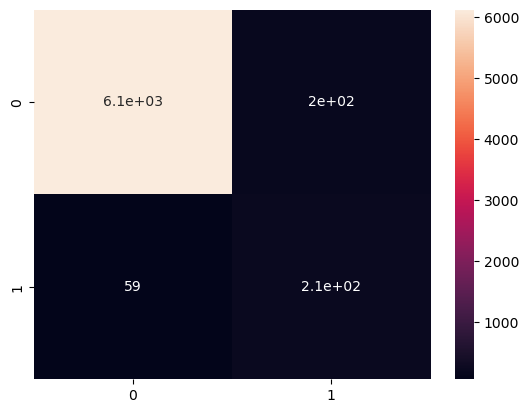

In [37]:
nb_epoch = 100
BS = 64
print("Training...")
milli_sec1 = int(round(time.time() * 1000))

userModel = "lstmCnn"#"lstm"

if userModel == "cnn":
    myModel = buildCnn(max_len, num_words, dim, seed, embedding_matrix) 
elif userModel == "lstm":
    myModel = buildLstm(max_len, num_words, dim, seed, embedding_matrix)
elif userModel == "lstmCnn":
    myModel = buildLstmCNN(max_len, num_words, dim, seed, embedding_matrix)
elif userModel == "lstmAtt":
    myModel = buildLstmWithBahdanauAttention(max_len, num_words, dim, seed, embedding_matrix)
    
print("model summary\m", myModel.summary())
csv_logger = CSVLogger('log.csv', append=True, separator=',')
es = EarlyStopping(monitor='val_f2_metric', mode='max', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_f2_metric', mode='max', verbose=1, save_best_only=True)

history = myModel.fit(lines_pad_x_train, y_train, validation_data=(lines_pad_x_val, y_val), epochs = nb_epoch, batch_size = BS, shuffle=True, verbose=1, callbacks=[csv_logger,es,mc], class_weight=class_weights)

#load best model
#model = load_model('best_model.h5')
myModel.load_weights("best_model.h5")

scores = myModel.evaluate(lines_pad_x_val, y_val, verbose=0)
#predictions = myModel.predict_classes(X_test, verbose=0)
predScores = myModel.predict(lines_pad_x_val)
predictions = (predScores > 0.5).astype("int32")

accuracy=accuracy_score(y_val, predictions)
precision=precision_score(y_val, predictions)
recall=recall_score(y_val, predictions)
f1=f1_score(y_val, predictions)
roc_auc=roc_auc_score(y_val, predictions)
f2=5*precision*recall / (4*precision+recall)

cm = confusion_matrix(y_val, predictions, labels=[0, 1])
#print(cm)
sns.heatmap(cm, annot=True)
tn, fp, fn, tp = cm.ravel()

print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)

acc = ((tp+tn)/(tp+tn+fp+fn))

print("Accuracy:%.2f%%"%(acc*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("F1 score:%.2f%%"%(f1*100))
print("Roc_Auc score:%.2f%%"%(roc_auc*100))
print("F2 score:%.2f%%"%(f2*100))
print(classification_report(y_val, predictions))

milli_sec2 = int(round(time.time() * 1000))
print("Cross Validation is completed after", milli_sec2-milli_sec1)

In [43]:
#load best model
myModel = load_model("best_model.h5", custom_objects={"f2_metric": f2_metric})

#y_val
predScores = myModel.predict(lines_pad_x_val)
predictions = (predScores > 0.5).astype("int32")

206/206 [==============================] - 11s 28ms/step


In [44]:
true_positives_indices = []

for i in range(len(y_val)):
    if y_val[i] == 1 and predictions[i][0] == 1:
        true_positives_indices.append(i)

true_positives = np.array(x_val)[true_positives_indices]


In [45]:
true_positives

array(['   virtual size_t getnumactiveinputmethods() {\n    scoped_ptr<inputmethoddescriptors> descriptors(getactiveinputmethods());\n     return descriptors->size();\n   }\n',
       'extensionttscontroller::~extensionttscontroller() {\n  finishcurrentutterance();\n  clearutterancequeue();\n}\n',
       ' void renderwidgethostviewandroid::acceleratedsurfacebuffersswapped(\n     const gpuhostmsg_acceleratedsurfacebuffersswapped_params& params,\n     int gpu_host_id) {\n  texture_layer_->settextureid(params.surface_handle);\n  dcheck(texture_layer_ == layer_);\n  layer_->setbounds(params.size);\n  texture_id_in_layer_ = params.surface_handle;\n  texture_size_in_layer_ = params.size;\n   dcheck(!compositorimpl::isthreadingenabled());\n   uint32 sync_point =\n       imagetransportfactoryandroid::getinstance()->insertsyncpoint();\n   renderwidgethostimpl::acknowledgebufferpresent(\n      params.route_id, gpu_host_id, true, sync_point);\n }\n',
       'globalhistogramallocator::releaseforte

In [46]:
from lime.lime_text import LimeTextExplainer

# We choose a sample from test set
idx = 0
text_sample = true_positives[idx]
class_names = ['neutral', 'vulnerable']
explainer = LimeTextExplainer(class_names=class_names)

print(text_sample)

   virtual size_t getnumactiveinputmethods() {
    scoped_ptr<inputmethoddescriptors> descriptors(getactiveinputmethods());
     return descriptors->size();
   }



In [50]:
# create a pipeline with text encoding and padding, ending with predict_proba
def pipeline(text_sample):
    model_variation = "microsoft/codebert-base-mlm" # "neulab/codebert-cpp"
    tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=False) # , do_lower_case=True
    codebert = TFAutoModel.from_pretrained(model_variation) # , from_pt=True

    codebert_embeddings = codebert.get_input_embeddings()
    embedding_matrix = codebert_embeddings.weights[0].numpy()
    num_words = len(embedding_matrix)
    dim = len(embedding_matrix[0])

    sequence = tokenizer(text_sample, return_tensors="tf", truncation=True, add_special_tokens=False)

    lines_pad_x_train = padSequences(sequence, max_len)
    lines_pad_x_train = [arr.tolist() for arr in lines_pad_x_train]
    lines_pad_x_train = np.array(lines_pad_x_train)

    #myModel = buildLstmCNN(max_len, num_words, dim, seed, embedding_matrix)
    myModel = load_model("best_model.h5", custom_objects={"f2_metric": f2_metric})

    predScores = myModel.predict(lines_pad_x_val)

In [51]:
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text_sample, pipeline, num_features=20)
exp.show_in_notebook(text=text_sample)

Some layers from the model checkpoint at microsoft/codebert-base-mlm were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at microsoft/codebert-base-mlm.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


50265


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).